# Analysis of the leaf relative uptake equation using leaf chamber measurements

Wu Sun

* Created: 2019-10-12
* Updated: 2022-04-03
* Adapted for release on 2022-04-08

## Import packages and configure settings

In [1]:
import os
import sys
from collections import namedtuple
from typing import Union

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rpy2
import seaborn as sns
import statsmodels.api as sm
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from matplotlib import gridspec
from rpy2 import robjects
from rpy2.robjects import numpy2ri
from scipy import interpolate, optimize, stats
from scipy.constants import atm as p_atm
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
sys.path.insert(0, os.getcwd() + "/..")  # noqa
import lru_eqn
from config import dirs  # import directory settings
from lru_eqn import (
    rel_uptake,
    assim_coupled,
    rel_uptake_coupled,
    lossfun_rel_uptake,
    lossfun_assim_coupled,
    lossfun_rel_uptake_coupled,
)
from sat_vap import p_sat_h2o

In [3]:
plt.rcParams["figure.dpi"] = 100
plt.rcParams["savefig.dpi"] = 300
# enforce TrueType fonts, not Type 3 fonts
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

## Define functions

In [4]:
def hourly_median(hours, series, all_hours=True):
    """
    Calculate hourly binned medians of a time series.

    Parameters
    ----------
    hours : array_like
        Time series of the hour number. Must be of the same length as `series`.
    series : array_like
        Time series of the data.
    all_hours : bool, optional
        Default is `True` to consider 24 hours. If `False`, only consider the
        hours that are present in the `hours` input.

    Returns
    -------
    hour_level : array_like
        Hour levels.
    median : array_like
        Median values by the hour.
    q1 : array_like
        First quartile values by the hour.
    q3 : array_like
        Third quartile values by the hour.

    """
    if all_hours:
        hour_level = np.arange(24)
    else:
        hour_level = np.unique(hours)
    med_hr = np.zeros(hour_level.size) + np.nan
    q1_hr = np.zeros(hour_level.size) + np.nan
    q3_hr = np.zeros(hour_level.size) + np.nan
    for i in range(hour_level.size):
        med_hr[i] = np.nanmedian(series[hours == hour_level[i]])
        q1_hr[i], q3_hr[i] = np.nanpercentile(
            series[hours == hour_level[i]], [25.0, 75]
        )

    HourlyMedianResult = namedtuple(
        "HourlyMedianResult", ("hour_level", "median", "q1", "q3")
    )
    return HourlyMedianResult(hour_level, med_hr, q1_hr, q3_hr)

## Read observations and calculate leaf flux ratios

Filtering criteria: (1) 0 < LRU < 10; (2) PAR > 100.

In [5]:
df_ch = pd.read_csv(f"{dirs.data}/sjm_ch_filtered.csv")

# drop the chamber flux data before UTC Julian day 150
df_ch = df_ch.query("doy_utc > 149").reset_index(drop=True)

In [6]:
timestamps = pd.Timestamp("2013-01-01") + pd.to_timedelta(
    df_ch["doy_local"].values, unit="D"
)

In [7]:
df_ch.columns

Index(['doy_utc', 'doy_local', 'cos_atm', 'co2_atm', 'h2o_atm', 'cos_can',
       'co2_can', 'h2o_can', 'cos_sfc', 'co2_sfc', 'h2o_sfc', 'sd_cos_atm',
       'sd_co2_atm', 'sd_h2o_atm', 'sd_cos_can', 'sd_co2_can', 'sd_h2o_can',
       'sd_cos_sfc', 'sd_co2_sfc', 'sd_h2o_sfc', 'cos_lcc_bld', 'co2_lcc_bld',
       'h2o_lcc_bld', 'cos_scc_bld', 'co2_scc_bld', 'h2o_scc_bld', 'fcos_lc',
       'fco2_lc', 'fh2o_lc', 'sd_fcos_lc', 'sd_fco2_lc', 'sd_fh2o_lc',
       'fcos_sc', 'fco2_sc', 'fh2o_sc', 'sd_fcos_sc', 'sd_fco2_sc',
       'sd_fh2o_sc', 'diff_cos', 'diff_co2', 'diff_h2o', 'T_log', 'T_atm',
       'rh_atm', 'f_ch_lc', 'f_ch_sc', 'T_ch_lc', 'T_ch_sc', 'T_leaf',
       'PAR_ch_c', 'PAR_EC', 'PAR_ch', 'Tch_b_lc', 'Tch_c_lc', 'Tch_a_lc',
       'rh_b_lc', 'rh_c_lc', 'rh_a_lc', 'Tch_b_sc', 'Tch_c_sc', 'Tch_a_sc',
       'rh_b_sc', 'rh_c_sc', 'rh_a_sc', 'VPD_atm', 'VPD_lc', 'VPD_sc',
       'sd_VPD_lc', 'sd_VPD_sc', 'MFVD_atm', 'MFVD_lc', 'MFVD_sc',
       'sd_MFVD_lc', 'sd_MFVD_sc', 'g_sw'

In [8]:
df_lru = (
    df_ch[
        [
            "fcos_lc",
            "sd_fcos_lc",
            "fco2_lc",
            "sd_fco2_lc",
            "cos_can",
            "co2_can",
            "h2o_can",
            "rh_b_lc",
            "VPD_lc",
            "PAR_ch",
            "T_leaf",
        ]
    ]
    .rename(
        columns={
            "fcos_lc": "fcos",
            "sd_fcos_lc": "se_fcos",
            "fco2_lc": "fco2",
            "sd_fco2_lc": "se_fco2",
            "cos_can": "cos",
            "co2_can": "co2",
            "h2o_can": "h2o",
            "rh_b_lc": "rh_ch",
            "VPD_lc": "vpd",
            "PAR_ch": "ppfd",
            "T_leaf": "T_leaf",
        }
    )
    .copy()
)
df_lru["rh_ch"] *= 1e-2
df_lru.loc[df_lru["rh_ch"] > 1.0, "rh_ch"] = 1.0  # cap RH at 100%

# calculate leaf surface RH
df_lru["rh_leaf"] = df_lru["h2o"].values * p_atm * 1e-3 / p_sat_h2o(df_lru["T_leaf"])
df_lru.loc[df_lru["rh_leaf"] > 1.0, "rh_leaf"] = 1.0  # cap RH at 100%

# vpd is no longer needed
# df_lru.loc[df_lru["vpd"] < 1e-8, "vpd"] = 1e-8  # prevent NaN values

df_lru["lru"] = df_lru["fcos"] / df_lru["cos"] / (df_lru["fco2"] / df_lru["co2"])
df_lru.insert(0, column="timestamp", value=timestamps)

In [9]:
# keep a copy that has low-light data for fitting CO2 assimilation rate only
df_lru_ll = df_lru.copy()
df_lru_ll.loc[
    (df_lru_ll["lru"] <= 0.0)
    | (df_lru_ll["lru"] > 10.0)
    | (df_lru_ll["fcos"] >= 0.0)
    | (df_lru_ll["fco2"] >= 0.0),
    "lru",
] = np.nan
df_lru_ll = df_lru_ll[np.isfinite(df_lru_ll["lru"])].reset_index(drop=True)

In [10]:
df_lru_ll.shape

(278, 14)

In [11]:
ppfd_lower_threshold = 100.0
lru_upper_threshold = 10.0
df_lru.loc[
    (df_lru["ppfd"] < ppfd_lower_threshold)
    | (df_lru["lru"] <= 0.0)
    | (df_lru["lru"] > lru_upper_threshold)
    | (df_lru["fcos"] >= 0.0)
    | (df_lru["fco2"] >= 0.0),
    "lru",
] = np.nan
df_lru.loc[
    (df_lru["fcos"].abs() < 2 * df_lru["se_fcos"].abs())
    | (df_lru["fco2"].abs() < 2 * df_lru["se_fco2"].abs()),
    "lru",
] = np.nan
df_lru = df_lru[np.isfinite(df_lru["lru"])].reset_index(drop=True)

In [12]:
df_lru.shape

(235, 14)

### Figure S3: Relative humidity at the leaf surface vs. that in the chamber air

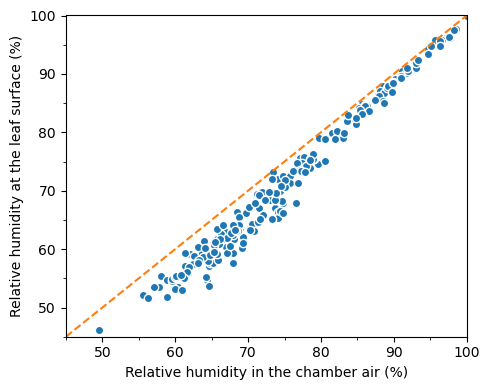

In [13]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(df_lru["rh_ch"] * 1e2, df_lru["rh_leaf"] * 1e2, "o", markeredgecolor="w")
ax.plot([45, 100], [45, 100], "--")
ax.set_xlim((45, 100))
ax.set_ylim((45, 100))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.set_xlabel("Relative humidity in the chamber air (%)")
ax.set_ylabel("Relative humidity at the leaf surface (%)")
fig.tight_layout()
fig.savefig(f"{dirs.plots}/rh-chamber-vs-leaf.pdf")
del fig, ax

## Fit the leaf relative uptake equation

### Fit the equation with known assimilation rates

In [14]:
?lossfun_rel_uptake

Signature:
lossfun_rel_uptake(
    m: float,
    g_is: float,
    assim: Union[float, numpy.ndarray],
    rh: Union[float, numpy.ndarray],
    co2: Union[float, numpy.ndarray],
    obs: numpy.ndarray,
) -> float
Docstring: L2 loss function for leaf relative uptake ratio.
File:      /central/home/wsun/tmp/leaf-relative-uptake/src/lru_eqn.py
Type:      function


In [15]:
params_init = np.array(
    [
        9.0,
        0.1,
    ]
)  # m [dimensionless]  # g_is [mol m^-2 s^-1]
params_bounds = [
    (1.0, 30.0),  # m [dimensionless]
    (1e-3, 10.0),  # g_is [mol m^-2 s^-1]
]


def lossfun_rel_uptake_packed(params, assim, rh, co2, obs):
    return lossfun_rel_uptake(params[0], params[1], assim, rh, co2, obs)


res1 = optimize.minimize(
    lossfun_rel_uptake_packed,
    params_init,
    args=(
        -df_lru["fco2"].values,
        df_lru["rh_leaf"].values,
        df_lru["co2"].values,
        df_lru["lru"].values,
    ),
    method="L-BFGS-B",
    bounds=params_bounds,
    options={"disp": True},
)

print(res1)
# estimated parameters
m_hat, g_is_hat = res1.x
print("\nestimated parameters:")
print(f"* m_hat = {m_hat}")
print(f"* gs_is_hat = {g_is_hat} mol m^-2 s^-1")

      fun: 0.10630632429550338
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.77555758e-09, 4.44089210e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 75
      nit: 20
     njev: 25
   status: 0
  success: True
        x: array([7.14852101, 0.02514717])

estimated parameters:
* m_hat = 7.148521012801397
* gs_is_hat = 0.025147174321528482 mol m^-2 s^-1


In [16]:
# predicted LRU values
lru_hat = rel_uptake(
    m_hat,
    g_is_hat,
    -df_lru["fco2"].values,
    df_lru["rh_leaf"].values,
    df_lru["co2"].values,
)

Pearson correlation between LRU_obs and LRU_hat = 0.6871928900566397
RMSE between LRU_obs and LRU_hat = 0.46109939122818927


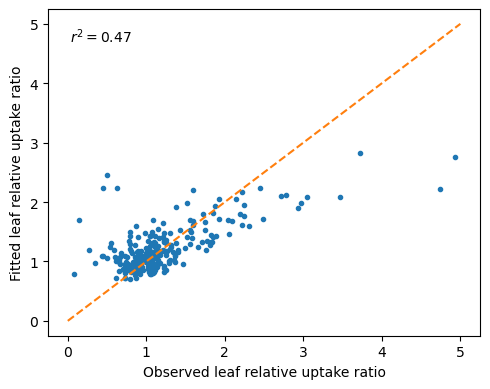

In [17]:
corr = stats.pearsonr(df_lru["lru"].values, lru_hat)[0]
print(f"Pearson correlation between LRU_obs and LRU_hat = {corr}")
rmse = np.nanmean((df_lru["lru"].values - lru_hat) ** 2.0) ** 0.5
print(f"RMSE between LRU_obs and LRU_hat = {rmse}")

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(df_lru["lru"].values, lru_hat, ".")
ax.plot([0, 5], [0, 5], "--")
ax.set_xlabel("Observed leaf relative uptake ratio")
ax.set_ylabel("Fitted leaf relative uptake ratio")
ax.text(0.05, 0.9, "$r^2 = {%.2f}$" % (corr * corr), transform=ax.transAxes)
fig.tight_layout()
del fig, ax

### Fit the equation with photosynthetic parameters

Due to the uncertainty in gas exchange measurements using leaf chambers (as opposed to LI-6400), and the relatively narrow ranges of PAR, RH, and ambient CO<sub>2</sub>, parameters to which the photosynthesis is insensitive cannot be robustly constrained. This is not surprising because chamber-based continuous measurements were not designed to constrain the _A–C_<sub>i</sub> curve or the CO<sub>2</sub> compensation point.

We will use best-guess values and/or constraints of the following parameters according to the literature:

* _m_ = 7.15 (fitted value from the generalized LRU equation)
* _g_<sub>i,S</sub> = 0.025 mol m<sup>–2</sup> s<sup>–1</sup> (fitted value from the generalized LRU equation)
* _f_<sub>PSII</sub> = 0.36 (von Caemmerer et al., 2009)
* Γ<sup>*</sup> = 27 pmol mol<sup>–1</sup> (McNaughton, 1974; using Fig. 3 and a mean air temperature of 18°C)
* _θ_ = 0.0 for leaves in high light and near the top (Jespersen et al., 2017) [N.B. If we let _θ_ vary between 0 and 1 in the optimization, it also converges to 0.]
<!-- * 0.01 ≤ _R_<sub>d</sub> / _J_<sub>max</sub> ≤ 0.04 (assuming _J_<sub>max</sub> / _V_<sub>c,max</sub> ≈ 5/3; Tinoco Ojanguren and Goulden, 2013; Jespersen et al., 2017) and _R_<sub>d</sub> ≤ _F_<sub>CO2,night</sub> -->

We will use the following initial values for parameters that are to be fitted:

* _K_<sub>co</sub> = 560 µmol mol<sup>–1</sup> (von Caemmerer et al., 2009)
* _J_<sub>max</sub> = 40.0 µmol m<sup>–2</sup> s<sup>–1</sup> (a guess value)
* _V_<sub>c,max</sub> = 24.0 µmol m<sup>–2</sup> s<sup>–1</sup> (a guess value; assuming _V_<sub>c,max</sub>/_J_<sub>max</sub> ≈ 3/5)
* _R_<sub>d</sub> = 0.5 µmol m<sup>–2</sup> s<sup>–1</sup> (a guess value)

In [18]:
VCMAX_JMAX_RATIO = 0.6  # a fixed assumption

In [19]:
?lossfun_assim_coupled

Signature:
lossfun_assim_coupled(
    m: float,
    v_cmax: float,
    k_co: float,
    co2_comp: float,
    resp: float,
    j_max: float,
    theta: float,
    f_psii: float,
    ppfd: Union[float, numpy.ndarray],
    rh: Union[float, numpy.ndarray],
    co2: Union[float, numpy.ndarray],
    obs: numpy.ndarray,
) -> float
Docstring: Loss function for the coupled assimilation rate.
File:      /central/home/wsun/tmp/leaf-relative-uptake/src/lru_eqn.py
Type:      function


In [20]:
resp_max_bound = df_ch.loc[df_ch.daytime_indicator == 0, "fco2_lc"].mean()

# k_co, resp, j_max
params_init = np.array([560, 0.5, 40.0])
params_bounds = [
    (1e1, 1e3),  # k_co [µmol mol^-1]
    (0.0, resp_max_bound),  # resp [µmol m^-2 s^-1]
    (10.0, 100.0),  # j_max [µmol m^-2 s^-1]
]

m_estimated = m_hat
co2_comp_default = 27.0
theta_default = 0.0
f_psii_default = 0.36


def lossfun_assim_coupled_packed(params, ppfd, rh, co2, obs):
    k_co, resp, j_max = params
    v_cmax = j_max * VCMAX_JMAX_RATIO
    m = m_estimated
    co2_comp = co2_comp_default
    theta = theta_default
    f_psii = f_psii_default
    return lossfun_assim_coupled(
        m,
        v_cmax,
        k_co,
        co2_comp,
        resp,
        j_max,
        theta,
        f_psii,
        ppfd,
        rh,
        co2,
        obs,
    )

In [21]:
res2 = optimize.minimize(
    lossfun_assim_coupled_packed,
    params_init,
    args=(
        df_lru_ll["ppfd"].values,
        df_lru_ll["rh_leaf"].values,
        df_lru_ll["co2"].values,
        -df_lru_ll["fco2"].values,
    ),
    method="L-BFGS-B",
    bounds=params_bounds,
    options={"disp": True, "gtol": 1e-8},
)
res2

      fun: 1.5403329226035558
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.07975623e-05, -2.86837221e-04,  8.65085709e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 268
      nit: 20
     njev: 67
   status: 0
  success: True
        x: array([5.97643580e+02, 4.76791676e-01, 3.54775104e+01])

In [22]:
# res2.x: k_co, resp, j_max
assim_params_fitted = [
    m_estimated,
    res2.x[2] * VCMAX_JMAX_RATIO,
    res2.x[0],
    co2_comp_default,
    *res2.x[1:],
    theta_default,
    f_psii_default,
]

In [23]:
# predicted co2 assimilation rates
assim_hat = assim_coupled(
    *assim_params_fitted,
    df_lru_ll["ppfd"].values,
    df_lru_ll["rh_leaf"].values,
    df_lru_ll["co2"].values,
)

Pearson correlation between assim_obs and assim_hat = 0.5587092506485101


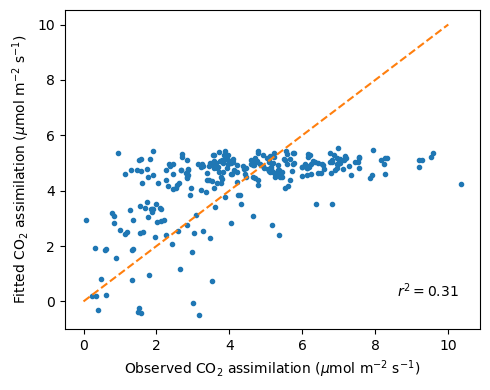

In [24]:
corr = stats.pearsonr(-df_lru_ll["fco2"].values, assim_hat)[0]
print(f"Pearson correlation between assim_obs and assim_hat = {corr}")

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(-df_lru_ll["fco2"].values, assim_hat, ".")
ax.plot([0, 10], [0, 10], "--")
ax.set_xlabel("Observed CO$_2$ assimilation ($\\mu$mol m$^{-2}$ s$^{-1}$)")
ax.set_ylabel("Fitted CO$_2$ assimilation ($\\mu$mol m$^{-2}$ s$^{-1}$)")
ax.text(0.8, 0.1, "$r^2 = {%.2f}$" % (corr * corr), transform=ax.transAxes)
fig.tight_layout()
del fig, ax

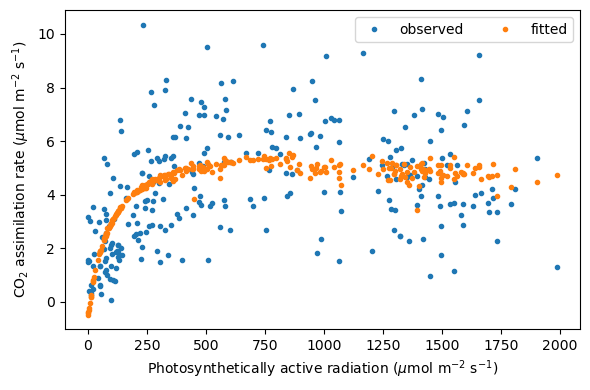

In [25]:
fig, ax = plt.subplots()
ax.plot(df_lru_ll["ppfd"].values, -df_lru_ll["fco2"].values, ".", label="observed")
ax.plot(df_lru_ll["ppfd"].values, assim_hat, ".", label="fitted")
ax.set_ylabel("CO$_2$ assimilation rate ($\\mu$mol m$^{-2}$ s$^{-1}$)")
ax.set_xlabel("Photosynthetically active radiation ($\\mu$mol m$^{-2}$ s$^{-1}$)")
ax.legend(loc="upper right", ncol=2)
fig.tight_layout()
del fig, ax

In [26]:
?lossfun_rel_uptake_coupled

Signature:
lossfun_rel_uptake_coupled(
    m: float,
    g_is: float,
    v_cmax: float,
    k_co: float,
    co2_comp: float,
    resp: float,
    j_max: float,
    theta: float,
    f_psii: float,
    ppfd: Union[float, numpy.ndarray],
    rh: Union[float, numpy.ndarray],
    co2: Union[float, numpy.ndarray],
    obs: numpy.ndarray,
) -> float
Docstring: Loss function for coupled equations of leaf relative uptake ratio.
File:      /central/home/wsun/tmp/leaf-relative-uptake/src/lru_eqn.py
Type:      function


In [27]:
resp_max_bound = df_ch.loc[df_ch.daytime_indicator == 0, "fco2_lc"].mean()

# g_is, k_co, resp, j_max
params_init = np.array([g_is_hat, res2.x[0], res2.x[1], res2.x[2]])
params_bounds = [
    (1e-4, 10.0),  # g_is [mol m^-2 s^-1]
    (1e1, 1e3),  # k_co [µmol mol^-1]
    (0.0, resp_max_bound),  # resp [µmol m^-2 s^-1]
    (10.0, 100.0),  # j_max [µmol m^-2 s^-1]
]

# m_estimated = m_hat
co2_comp_default = 27.0
theta_default = 0.0
f_psii_default = 0.36


def lossfun_rel_uptake_coupled_packed(params, ppfd, rh, co2, obs):
    g_is, k_co, resp, j_max = params
    v_cmax = j_max * VCMAX_JMAX_RATIO
    m = m_estimated
    co2_comp = co2_comp_default
    theta = theta_default
    f_psii = f_psii_default
    return lossfun_rel_uptake_coupled(
        m,
        g_is,
        v_cmax,
        k_co,
        co2_comp,
        resp,
        j_max,
        theta,
        f_psii,
        ppfd,
        rh,
        co2,
        obs,
    )

In [28]:
res3 = optimize.minimize(
    lossfun_rel_uptake_coupled_packed,
    params_init,
    args=(
        df_lru["ppfd"].values,
        df_lru["rh_leaf"].values,
        df_lru["co2"].values,
        df_lru["lru"].values,
    ),
    method="L-BFGS-B",
    bounds=params_bounds,
    options={"disp": True, "gtol": 1e-8},
)
res3

      fun: 0.14676250831685808
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.65667521e-04,  5.25384874e-05, -4.75226245e-03, -5.20308753e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 120
      nit: 18
     njev: 24
   status: 0
  success: True
        x: array([2.67568296e-02, 5.97639652e+02, 8.00189109e-01, 3.55185186e+01])

In [29]:
# res3.x: g_is, k_co, resp, j_max
coupled_params_fitted = [
    m_estimated,
    res3.x[0],
    res3.x[3] * VCMAX_JMAX_RATIO,
    res3.x[1],
    co2_comp_default,
    *res3.x[2:],
    theta_default,
    f_psii_default,
]

In [30]:
# predicted LRU values
lru_coupled_hat = rel_uptake_coupled(
    *coupled_params_fitted,
    df_lru["ppfd"].values,
    df_lru["rh_leaf"].values,
    df_lru["co2"].values,
)

Pearson correlation between LRU_obs and LRU_coupled_hat = 0.5738483520252038
RMSE between LRU_obs and LRU_coupled_hat = 0.5417794907835809


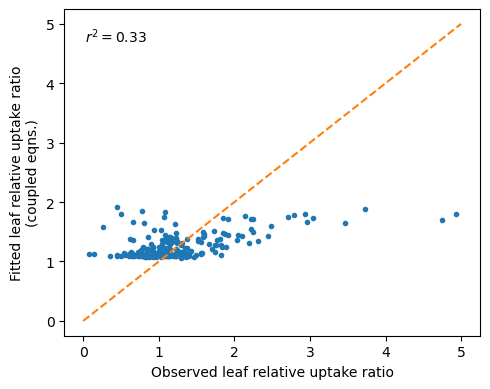

In [31]:
corr = stats.pearsonr(df_lru["lru"].values, lru_coupled_hat)[0]
print(f"Pearson correlation between LRU_obs and LRU_coupled_hat = {corr}")
rmse = np.nanmean((df_lru["lru"].values - lru_coupled_hat) ** 2.0) ** 0.5
print(f"RMSE between LRU_obs and LRU_coupled_hat = {rmse}")

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(df_lru["lru"].values, lru_coupled_hat, ".")
ax.plot([0, 5], [0, 5], "--")
ax.set_xlabel("Observed leaf relative uptake ratio")
ax.set_ylabel("Fitted leaf relative uptake ratio\n(coupled eqns.)")
ax.text(0.05, 0.9, "$r^2 = {%.2f}$" % (corr * corr), transform=ax.transAxes)
fig.tight_layout()
del fig, ax

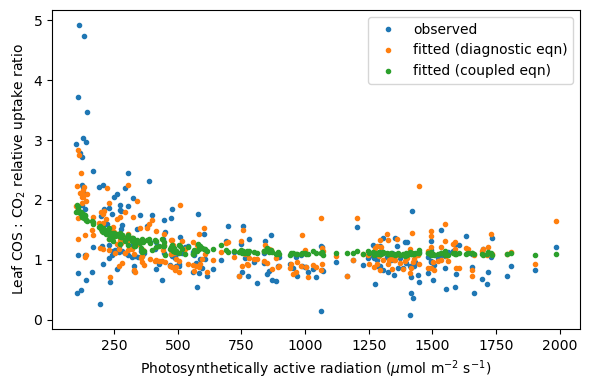

In [32]:
fig, ax = plt.subplots()

ax.plot(df_lru["ppfd"].values, df_lru["lru"].values, ".", label="observed")
ax.plot(df_lru["ppfd"].values, lru_hat, ".", label="fitted (diagnostic eqn)")
ax.plot(df_lru["ppfd"].values, lru_coupled_hat, ".", label="fitted (coupled eqn)")
ax.set_ylabel("Leaf COS : CO$_2$ relative uptake ratio")
ax.set_xlabel("Photosynthetically active radiation ($\\mu$mol m$^{-2}$ s$^{-1}$)")
ax.legend(loc="upper right")
fig.tight_layout()
del fig, ax

### Summary of fitted parameters

In [33]:
FittedParams = namedtuple(
    "FittedParams",
    [
        "m",
        "g_is",
        "v_cmax",
        "k_co",
        "co2_comp",
        "resp",
        "j_max",
        "theta",
        "f_psii",
        "is_fixed",
    ],
)
fitted_params = FittedParams(*coupled_params_fitted, [0, 0, 1, 0, 1, 0, 0, 1, 1])

In [34]:
fitted_params

FittedParams(m=7.148521012801397, g_is=0.026756829632024696, v_cmax=21.31111116688869, k_co=597.6396515743719, co2_comp=27.0, resp=0.8001891089108911, j_max=35.51851861148115, theta=0.0, f_psii=0.36, is_fixed=[0, 0, 1, 0, 1, 0, 0, 1, 1])

## Visualization of fitted LRU relationship

In [35]:
# lowess nonparameteric smoothing
lowess_lru_par = lowess(df_lru["lru"].values, df_lru["ppfd"].values, frac=0.5)
lowess_lru_rh = lowess(df_lru["lru"].values, df_lru["rh_leaf"].values, frac=0.5)

### Figure 2: LRU vs PAR and RH

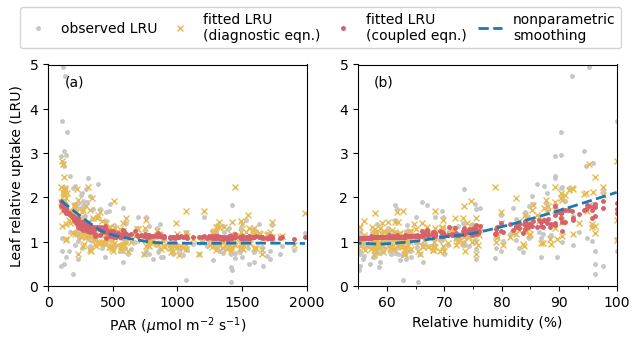

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(6.5, 3.5), sharey=True)
ax[0].plot(
    df_lru["ppfd"], df_lru["lru"], ".", c=plt.cm.tab20(15), ms=5, label="observed LRU"
)
ax[0].plot(
    df_lru["ppfd"],
    lru_hat,
    "x",
    c=plt.cm.tab20b(10),
    ms=5,
    label="fitted LRU\n(diagnostic eqn.)",
)
ax[0].plot(
    df_lru["ppfd"],
    lru_coupled_hat,
    ".",
    c=plt.cm.tab20b(14),
    ms=5,
    label="fitted LRU\n(coupled eqn.)",
)
ax[0].plot(
    lowess_lru_par[:, 0],
    lowess_lru_par[:, 1],
    "--",
    c="tab:blue",
    lw=2,
    label="nonparametric\nsmoothing",
)
ax[0].set_xlim((0, 2000))
ax[0].set_ylim((0, 5))
ax[0].set_xlabel("PAR ($\mu$mol m$^{-2}$ s$^{-1}$)")
ax[0].set_ylabel("Leaf relative uptake (LRU)")
ax[0].text(0.1, 0.92, "(a)", va="center", ha="center", transform=ax[0].transAxes)

ax[1].plot(
    df_lru["rh_leaf"] * 1e2,
    df_lru["lru"],
    ".",
    c=plt.cm.tab20(15),
    ms=5,
    label="observed LRU",
)
ax[1].plot(
    df_lru["rh_leaf"] * 1e2,
    lru_hat,
    "x",
    c=plt.cm.tab20b(10),
    ms=5,
    label="fitted LRU\n(diagnostic eqn.)",
)
ax[1].plot(
    df_lru["rh_leaf"] * 1e2,
    lru_coupled_hat,
    ".",
    c=plt.cm.tab20b(14),
    ms=5,
    label="fitted LRU\n(coupled eqn.)",
)
ax[1].plot(
    lowess_lru_rh[:, 0] * 100,
    lowess_lru_rh[:, 1],
    "--",
    c="tab:blue",
    lw=2,
    label="nonparametric\nsmoothing",
)
ax[1].set_xlim((55, 100))
ax[1].xaxis.set_minor_locator(MultipleLocator(5))
ax[1].set_xlabel("Relative humidity (%)")
ax[1].tick_params(axis="y", labelleft=True)
ax[1].text(0.1, 0.92, "(b)", va="center", ha="center", transform=ax[1].transAxes)
fig.tight_layout(rect=(0.0, 0.0, 1.0, 0.88))
fig.legend(
    handles=ax[0].get_lines(),
    ncol=4,
    loc=(0.031, 0.86),
    handlelength=1.75,
    columnspacing=0.75,
    fontsize=10,
    frameon=True,
)
fig.savefig(f"{dirs.plots}/marsh-lru-par-rh.pdf")
del fig, ax

### Figure 3: A contour plot of LRU dependence on PAR and RH

In [37]:
# define colormap normalizer
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y, left=0, right=1))

In [38]:
ppfd_grid, rh_grid = np.meshgrid(np.arange(0, 2050, 50), np.arange(0.25, 1.01, 0.01))
co2_avg = df_lru["co2"].mean()
lru_grid = rel_uptake_coupled(*coupled_params_fitted, ppfd_grid, rh_grid, co2_avg)

In [39]:
# color normalizer: no longer needed if extend='max' is used
vmin = np.floor(lru_grid.min() * 10.0) * 0.1
vmax = np.ceil(lru_grid[ppfd_grid > 100.0].max() * 10.0) * 0.1 + 0.1
midpoint = vmin + 0.6
cmap_normalizer = MidpointNormalize(midpoint=midpoint, vmax=vmax, vmin=vmin)

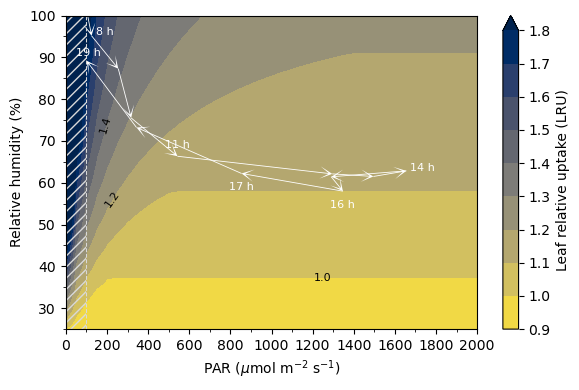

In [40]:
fig, ax = plt.subplots(figsize=(6, 4))
cntr = ax.contourf(
    ppfd_grid,
    rh_grid * 1e2,
    lru_grid,
    levels=np.arange(vmin, vmax, 0.1),
    # norm=cmap_normalizer,
    extend="max",
    antialiased=False,
    cmap="cividis_r",
)
# note: contour lines are only used to position the numbers, therefore they
# need to be hidden using colors='None'. Disable 'antialiased' because it may
# show white boundaries between meshes.
cntrln = ax.contour(
    ppfd_grid[:, 3:],
    rh_grid[:, 3:] * 1e2,
    lru_grid[:, 3:],
    levels=np.arange(vmin + 0.1, vmax, 0.2),
    colors="None",
    antialiased=False,
)
plt.clabel(
    cntrln,
    np.arange(vmin + 0.1, vmin + 0.6, 0.2),
    fmt="%.1f",
    fontsize=8,
    inline=True,
    colors="k",
)
# overlay hatching
ax.fill(
    [0.0, 100.0, 100.0, 0.0],
    [25.0, 25.0, 100.0, 100.0],
    hatch="///",
    edgecolor=plt.cm.tab20c(19),
    alpha=1,
    linewidth=0.0,
    fill=False,
)
ax.axvline(100.0, linestyle="dashed", color=plt.cm.tab20c(19), linewidth=0.75)

cbar = fig.colorbar(cntr, label="Leaf relative uptake (LRU)")
cbar.set_ticks(np.arange(vmin, vmax, 0.1))
ax.set_xlabel("PAR ($\mu$mol m$^{-2}$ s$^{-1}$)")
ax.set_ylabel("Relative humidity (%)")
ax.set_xlim([0, 2000])
ax.set_ylim([25, 100])  # do not show the low RH region
ax.xaxis.set_major_locator(MultipleLocator(200))
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.yaxis.set_minor_locator(MultipleLocator(5))
fig.tight_layout()

# overlay the PAR--RH hysteresis curve  # added 2017-11-19
ppfd_hrmed = hourly_median(
    df_lru["timestamp"].dt.hour.values, df_lru["ppfd"].values, all_hours=False
)
rh_hrmed = hourly_median(
    df_lru["timestamp"].dt.hour.values, df_lru["rh_leaf"].values * 1e2, all_hours=False
)
ax.quiver(
    ppfd_hrmed.median[:-1],
    rh_hrmed.median[:-1],
    ppfd_hrmed.median[1:] - ppfd_hrmed.median[:-1],
    rh_hrmed.median[1:] - rh_hrmed.median[:-1],
    scale_units="xy",
    angles="xy",
    scale=1,
    width=2e-3,
    headwidth=15,
    headlength=15,
    color="w",
)
ax.text(
    ppfd_hrmed.median[7] + 20,
    rh_hrmed.median[7],
    "%i h" % ppfd_hrmed.hour_level[7],
    fontsize=8,
    color="w",
)
ax.text(
    ppfd_hrmed.median[12] - 50,
    rh_hrmed.median[12] + 1,
    "%i h" % ppfd_hrmed.hour_level[12],
    fontsize=8,
    color="w",
)
ax.text(
    ppfd_hrmed.median[1] + 20,
    rh_hrmed.median[1] + 1,
    "%i h" % ppfd_hrmed.hour_level[1],
    fontsize=8,
    color="w",
    va="center",
)
ax.text(
    ppfd_hrmed.median[9],
    rh_hrmed.median[9] - 4,
    "%i h" % ppfd_hrmed.hour_level[9],
    fontsize=8,
    color="w",
    ha="center",
)
ax.text(
    ppfd_hrmed.median[10],
    rh_hrmed.median[10] - 4,
    "%i h" % ppfd_hrmed.hour_level[10],
    fontsize=8,
    color="w",
    ha="center",
)
ax.text(
    ppfd_hrmed.median[4],
    rh_hrmed.median[4] + 2,
    "%i h" % ppfd_hrmed.hour_level[4],
    fontsize=8,
    color="w",
    ha="center",
)
fig.savefig(f"{dirs.plots}/marsh-lru-par-rh-contour.pdf")
del fig, ax

### Figure S4: 2D LOWESS patterns

In [41]:
rloess = robjects.r["loess"]
rpy2.robjects.numpy2ri.activate()

In [42]:
# must use degree=1 (linear), not 2 (quadratic) because the latter will distort
# the curve at densely sampled locales.
lo_res = rloess(
    "lru ~ ppfd * rh",
    data=robjects.DataFrame(
        {
            "lru": df_lru["lru"].values,
            "ppfd": df_lru["ppfd"].values,
            "rh": df_lru["rh_leaf"].values,
        }
    ),
    degree=1,
)
# extract the fitted values to python memory space
lru_loess = np.asarray(lo_res.rx2("fitted"))
# calculate diagnostics
r2_loess = stats.pearsonr(lru_loess, df_lru["lru"].values)[0] ** 2
rmse_loess = np.nanmean((df_lru["lru"].values - lru_loess) ** 2) ** 0.5

In [43]:
# regrid the fitted values to make contour plots
_xcoords = np.arange(100.0, 2001.0, 20.0)
_ycoords = np.arange(0.45, 1.005, 0.01)
_xydim = (_ycoords.shape[0], _xcoords.shape[0])
_xgrid = np.tile(_xcoords, _xydim[0])
_ygrid = np.repeat(_ycoords, _xydim[1])
ppfd_gridded = _xgrid.reshape(_xydim)
rh_gridded = _ygrid.reshape(_xydim)

lru_loess_gridded = interpolate.griddata(
    df_lru[["ppfd", "rh_leaf"]].values,
    lru_loess,
    np.vstack((_xgrid, _ygrid)).T,
    method="linear",
).reshape(_xydim)
del _xcoords, _ycoords, _xydim

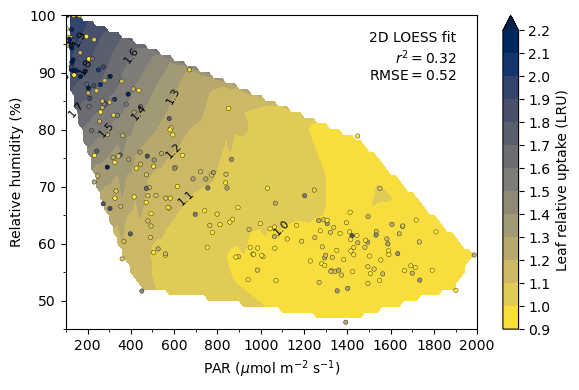

In [44]:
fig, ax = plt.subplots()
vmin = np.floor(np.nanmin(lru_loess_gridded) * 10.0) * 0.1
vmax = np.ceil(np.nanmax(lru_loess_gridded) * 10.0) * 0.1 + 0.1
cntr = ax.contourf(
    ppfd_gridded,
    rh_gridded * 1e2,
    lru_loess_gridded,
    levels=np.arange(vmin, vmax, 0.1),
    extend="max",
    antialiased=False,
    cmap="cividis_r",
)

# note: contour lines are only used to position the numbers, therefore they
# need to be hidden using colors='None'. Disable 'antialiased' because it may
# show white boundaries between meshes.
cntrln = ax.contour(
    ppfd_gridded,
    rh_gridded * 1e2,
    lru_loess_gridded,
    levels=np.arange(vmin, vmax, 0.1),
    colors="None",
    antialiased=False,
)
plt.clabel(
    cntrln,
    np.arange(vmin, vmin + 1.1, 0.1),
    fmt="%.1f",
    fontsize=8,
    inline=True,
    colors="k",
)

cbar = fig.colorbar(cntr, label="Leaf relative uptake (LRU)")
cbar.set_ticks(np.arange(vmin, vmax, 0.1))

# label observations
ax.scatter(
    df_lru["ppfd"].values,
    df_lru["rh_leaf"].values * 1e2,
    s=10,
    c=df_lru["lru"].values,
    edgecolor="k",
    linewidths=0.25,
    cmap="cividis_r",
    vmin=vmin,
    vmax=vmax,
    zorder=2,
)

ax.set_xlabel("PAR ($\mu$mol m$^{-2}$ s$^{-1}$)")
ax.set_ylabel("Relative humidity (%)")
ax.set_xlim([100, 2000])
ax.set_ylim([45, 100])  # do not show the low RH region
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_major_locator(MultipleLocator(200))
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.yaxis.set_minor_locator(MultipleLocator(5))

ax.text(
    0.95,
    0.95,
    f"2D LOESS fit\n$r^2 = {r2_loess:.2f}$\nRMSE$ = {rmse_loess:.2f}$",
    transform=ax.transAxes,
    ha="right",
    va="top",
    fontsize=10,
)

fig.tight_layout()
fig.savefig(f"{dirs.plots}/marsh-lru-par-rh-contour-loess.pdf")

del fig, ax, cntr, cntrln, cbar

### Figure 4: Parameter nudging tests

The four scenarios are:

* Double Ball–Berry slope
* Half Ball–Berry slope
* Double _J_<sub>max</sub> and _V_<sub>c,max</sub>
* Half _J_<sub>max</sub> and _V_<sub>c,max</sub>

For better visualization, switch to log scale for PAR.

In [45]:
fitted_params

FittedParams(m=7.148521012801397, g_is=0.026756829632024696, v_cmax=21.31111116688869, k_co=597.6396515743719, co2_comp=27.0, resp=0.8001891089108911, j_max=35.51851861148115, theta=0.0, f_psii=0.36, is_fixed=[0, 0, 1, 0, 1, 0, 0, 1, 1])

In [46]:
ppfd_logxgrid, rh_logxgrid = np.meshgrid(
    np.logspace(2, 3 + np.log10(2), 101), np.arange(0.25, 1.01, 0.01)
)
co2_const = 400.0
lru_pred_logxgrid = rel_uptake_coupled(
    *coupled_params_fitted,
    ppfd_logxgrid,
    rh_logxgrid,
    co2_const,
)

nudged_params_dict = {
    0: coupled_params_fitted
    * np.array([2.0, 1, 1, 1, 1, 1, 1, 1, 1]),  # double BB-slope
    1: coupled_params_fitted * np.array([0.5, 1, 1, 1, 1, 1, 1, 1, 1]),  # half BB-slope
    2: coupled_params_fitted
    * np.array(
        [1, 1, 2.0, 1, 1, 1, 2.0, 1, 1]
    ),  # double J_max and V_cmax (i.e., half kv_ratio)
    3: coupled_params_fitted
    * np.array(
        [1, 1, 0.5, 1, 1, 1, 0.5, 1, 1]
    ),  # half J_max and V_cmax (i.e., double kv_ratio)
}
nudged_lru_dict = {
    i: rel_uptake_coupled(
        *nudged_params_dict[i],
        ppfd_logxgrid,
        rh_logxgrid,
        co2_const,
    )
    for i in range(4)
}
# block low RH values for the 'half m' scenario
nudged_lru_dict[1][rh_logxgrid < 0.45] = np.nan

nudged_lru_ranges = [
    [
        float(np.ceil(np.nanmin(nudged_lru_dict[i]) * 10.0) * 0.1),
        float(np.ceil(np.nanmax(nudged_lru_dict[i]) * 10.0) * 0.1),
    ]
    for i in range(4)
]

nudged_test_names = [
    "(a) Double $m$",
    "(b) Half $m$",
    "(c) Double $J_\mathrm{max}$ and $V_\mathrm{c,max}$",
    "(d) Half $J_\mathrm{max}$ and $V_\mathrm{c,max}$",
]

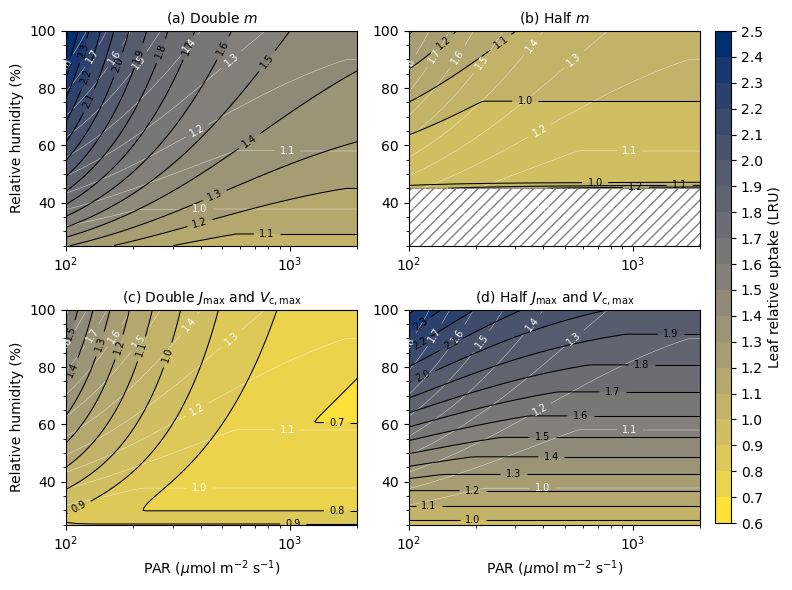

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
vmin = 0.6
vmax = 2.6
for i in range(4):
    ax = axes[i // 2, i % 2]
    # nudged contour plot
    cntr = ax.contourf(
        ppfd_logxgrid,
        rh_logxgrid * 100.0,
        nudged_lru_dict[i],
        levels=np.arange(vmin, vmax, 0.1),
        vmin=vmin,
        vmax=vmax,
        antialiased=False,
        cmap="cividis_r",
    )
    ax.set_xlim([100, 2000])
    ax.set_ylim([25, 100])  # do not show the low RH region
    # switch to logarithmic scale for x-axis
    ax.set_xscale("log")
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.set_title(nudged_test_names[i], fontsize=10)
    # contour lines of the original plot
    cntrln_orig = ax.contour(
        ppfd_logxgrid,
        rh_logxgrid * 100.0,
        lru_pred_logxgrid,
        linewidths=0.25,
        levels=np.arange(vmin, vmax, 0.1),
        colors="w",
        antialiased=True,
    )
    plt.clabel(
        cntrln_orig,
        np.arange(vmin, vmax, 0.1),
        fmt="%.1f",
        fontsize=7,
        inline=True,
        colors="w",
    )
    # contour lines of the nudged contour plot
    cntrln_nudged = ax.contour(
        ppfd_logxgrid,
        rh_logxgrid * 100.0,
        nudged_lru_dict[i],
        linewidths=0.75,
        levels=np.arange(*nudged_lru_ranges[i], 0.1),
        colors="k",
        antialiased=True,
    )
    plt.clabel(
        cntrln_nudged,
        np.arange(*nudged_lru_ranges[i], 0.1),
        fmt="%.1f",
        fontsize=7,
        inline=True,
        colors="k",
    )

# add hatch for the scenario of half m
axes[0, 1].fill(
    [1e2, 2e3, 2e3, 1e2],
    [0.0, 0.0, 45.0, 45.0],
    hatch="///",
    edgecolor="tab:gray",
    alpha=1,
    linewidth=0.0,
    fill=False,
)
axes[0, 1].axhline(45.0, linestyle="dashed", color="tab:gray", linewidth=0.75)


# add labels
for i in range(2):
    axes[1, i].set_xlabel("PAR ($\mu$mol m$^{-2}$ s$^{-1}$)")
    axes[i, 0].set_ylabel("Relative humidity (%)")

fig.tight_layout(rect=[0, 0, 0.9, 1])
cax = fig.add_axes([0.9, 0.12, 0.02, 0.82])
cbar = fig.colorbar(
    cntr, cax=cax, ticks=np.arange(vmin, vmax, 0.1), label="Leaf relative uptake (LRU)"
)

fig.savefig(f"{dirs.plots}/marsh-lru-param-tests.pdf")
del fig, axes, ax, cntr, cax, cbar

### Figure 5: Statistical distributions of LRU with parameter nudging

Simulate the kernel density distribution of LRU in the typical summer marsh enviroment.

In [48]:
kde_lru_obs = sm.nonparametric.KDEUnivariate(df_lru["lru"].values)
kde_lru_obs.fit()
kde_lru_pred = sm.nonparametric.KDEUnivariate(lru_coupled_hat)
kde_lru_pred.fit()

lru_pred_double_m = rel_uptake_coupled(
    *nudged_params_dict[0],
    df_lru["ppfd"].values,
    df_lru["rh_leaf"].values,
    df_lru["co2"].values,
)
lru_pred_half_m = rel_uptake_coupled(
    *nudged_params_dict[1],
    df_lru["ppfd"].values,
    df_lru["rh_leaf"].values,
    df_lru["co2"].values,
)
lru_pred_double_vcmax = rel_uptake_coupled(
    *nudged_params_dict[2],
    df_lru["ppfd"].values,
    df_lru["rh_leaf"].values,
    df_lru["co2"].values,
)
lru_pred_half_vcmax = rel_uptake_coupled(
    *nudged_params_dict[3],
    df_lru["ppfd"].values,
    df_lru["rh_leaf"].values,
    df_lru["co2"].values,
)

kde_lru_pred_double_m = sm.nonparametric.KDEUnivariate(lru_pred_double_m)
kde_lru_pred_double_m.fit()
kde_lru_pred_half_m = sm.nonparametric.KDEUnivariate(lru_pred_half_m)
kde_lru_pred_half_m.fit()

kde_lru_pred_double_vcmax = sm.nonparametric.KDEUnivariate(lru_pred_double_vcmax)
kde_lru_pred_double_vcmax.fit()
kde_lru_pred_half_vcmax = sm.nonparametric.KDEUnivariate(lru_pred_half_vcmax)
kde_lru_pred_half_vcmax.fit()

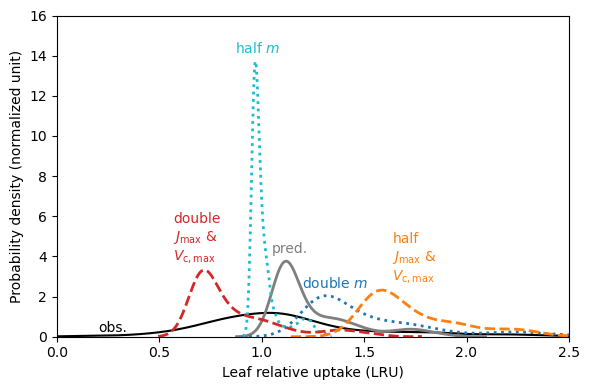

In [49]:
fig, ax = plt.subplots()

for _kde, _color, _linestyle, _lw, _label, _x_offset in zip(
    [
        kde_lru_obs,
        kde_lru_pred,
        kde_lru_pred_double_m,
        kde_lru_pred_half_m,
        kde_lru_pred_double_vcmax,
        kde_lru_pred_half_vcmax,
    ],
    ["k", "tab:gray", "tab:blue", "tab:cyan", "tab:red", "tab:orange"],
    ["-", "-", ":", ":", "--", "--"],
    [None, 2, 2, 2, 2, 2],
    [
        "obs.",
        "pred.",
        "double $m$",
        "half $m$",
        "double\n$J_\\mathrm{max}$ &\n$V_\\mathrm{c,max}$",
        "half\n$J_\\mathrm{max}$ &\n$V_\\mathrm{c,max}$",
    ],
    [0.0, -0.07, -0.12, -0.1, -0.15, 0.05],
):
    ax.plot(_kde.support, _kde.density, _linestyle, c=_color, lw=_lw)
    if "obs" in _label:
        ax.text(0.2, 0.25, _label, color=_color, fontsize=10)
    else:
        pos_x = _kde.support[np.argmax(_kde.density)]
        pos_y = np.max(_kde.density)
        ax.text(
            pos_x + _x_offset,
            pos_y + 0.25,
            _label,
            color=_color,
            fontsize=10,
            ha="left",
            va="bottom",
        )

ax.set_xlim((0, 2.5))
ax.set_ylim((0, 16))
ax.set_xlabel("Leaf relative uptake (LRU)")
ax.set_ylabel("Probability density (normalized unit)")

fig.tight_layout()
fig.savefig(f"{dirs.plots}/marsh-lru-param-tests-dist.pdf")

del fig, ax

### Figure 6: Asymptotic LRU as a function of stomatal sensitvity parameter and photosynthetic capacity

Resample statistical distributions of key parameters to calculate asymptotic LRU distribution.

In [50]:
# define the numerical asymptotic conditions as PAR = 2000 and RH = 0.5
ppfd_minlru = 2000.0
rh_minlru = 0.50
co2_minlru = 385.0
m_multiplier = np.linspace(0.5, 2.3, 91)
vcmax_multiplier = np.linspace(0.5, 3.0, 101)
m_multiplier_grid, vcmax_multiplier_grid = np.meshgrid(m_multiplier, vcmax_multiplier)
minlru_grid = np.full_like(m_multiplier_grid, np.nan)
for i in range(m_multiplier_grid.shape[0]):
    for j in range(m_multiplier_grid.shape[1]):
        minlru_grid[i, j] = rel_uptake_coupled(
            coupled_params_fitted[0] * m_multiplier_grid[i, j],
            coupled_params_fitted[1],
            coupled_params_fitted[2] * vcmax_multiplier_grid[i, j],
            coupled_params_fitted[3],
            coupled_params_fitted[4],
            coupled_params_fitted[5],
            coupled_params_fitted[6] * vcmax_multiplier_grid[i, j],
            coupled_params_fitted[7],
            coupled_params_fitted[8],
            ppfd_minlru,
            rh_minlru,
            co2_minlru,
        )

m_grid = m_multiplier_grid * coupled_params_fitted[0]
jmax_grid = vcmax_multiplier_grid * coupled_params_fitted[6]

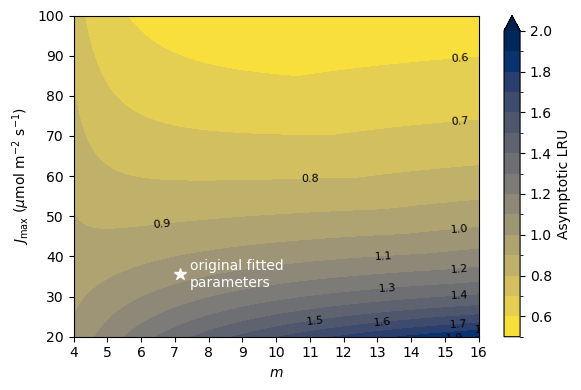

In [51]:
fig, ax = plt.subplots()
vmin = np.floor(np.nanmin(minlru_grid) * 10.0) * 0.1
vmax = np.ceil(np.nanmax(minlru_grid) * 10.0) * 0.1
cntr = ax.contourf(
    m_grid,
    jmax_grid,
    minlru_grid,
    levels=np.arange(vmin, vmax, 0.1),
    extend="max",
    antialiased=False,
    cmap="cividis_r",
)

# note: contour lines are only used to position the numbers, therefore they
# need to be hidden using colors='None'. Disable 'antialiased' because it may
# show white boundaries between meshes.
cntrln = ax.contour(
    m_grid,
    jmax_grid,
    minlru_grid,
    levels=np.arange(vmin, vmax, 0.1),
    colors="None",
    antialiased=False,
)
plt.clabel(
    cntrln,
    np.arange(vmin, vmin + 1.5, 0.1),
    fmt="%.1f",
    fontsize=8,
    inline=True,
    colors="k",
)

cbar = fig.colorbar(cntr, label="Asymptotic LRU")
cbar.set_ticks(np.arange(vmin + 0.1, vmax, 0.2))
cbar.ax.yaxis.set_minor_locator(MultipleLocator(0.1))

ax.set_xlabel("$m$")
ax.set_ylabel("$J_\\mathrm{max}$ ($\\mu$mol m$^{-2}$ s$^{-1}$)")
ax.set_xlim([4, 16])
ax.set_ylim([20, 100])
ax.xaxis.set_major_locator(MultipleLocator(1))

ax.plot([fitted_params.m], [fitted_params.j_max], "*", color="w", markersize=9)
ax.text(
    fitted_params.m + 0.3,
    fitted_params.j_max,
    "original fitted\nparameters",
    va="center",
    color="w",
    fontsize=10,
)

fig.tight_layout()
fig.savefig(f"{dirs.plots}/marsh-asymptotic-lru.pdf")

del fig, ax, cntr, cntrln, cbar

### Figure 7: Pre-industrial and future LRU at the marsh site

Preindustrial CO<sub>2</sub> conditions are scaled proportionally based on an atmosphere of 285 ppmv CO<sub>2</sub>. The CO<sub>2</sub> level at 2013 (when the experiments were conducted) is assumed to be 400 ppmv for simplicity.

Northern Hemisphere mean CO<sub>2</sub> in summer 2013 is close to 400 ppm.

In [52]:
LRU_preind = rel_uptake_coupled(
    *coupled_params_fitted,
    df_lru["ppfd"].values,
    df_lru["rh_leaf"].values,
    df_lru["co2"].values * 285.0 / 400.0,
)
LRU_dblco2 = rel_uptake_coupled(
    *coupled_params_fitted,
    df_lru["ppfd"].values,
    df_lru["rh_leaf"].values,
    df_lru["co2"].values * 2.0,
)

df_lru_co2 = pd.DataFrame(
    {
        "hour": df_lru["timestamp"].dt.hour.values,
        "ppfd": df_lru["ppfd"].values,
        "rh_leaf": df_lru["rh_leaf"].values,
        "lru_obs": df_lru["lru"].values,
        "lru_fitted": lru_coupled_hat,
        "lru_preind": LRU_preind,
        "lru_dblco2": LRU_dblco2,
    }
)

# realign the dataframe for boxplot
df_lru_co2_realigned = (
    df_lru_co2[["hour", "lru_fitted", "lru_preind", "lru_dblco2"]]
    .copy()
    .rename(
        columns={
            "lru_fitted": "present",
            "lru_preind": "preindustrial",
            "lru_dblco2": "CO$_2$ doubling",
        }
    )
)
df_lru_co2_realigned = pd.melt(
    df_lru_co2_realigned,
    id_vars=["hour"],
    value_vars=["present", "preindustrial", "CO$_2$ doubling"],
    var_name="Scenarios",
)

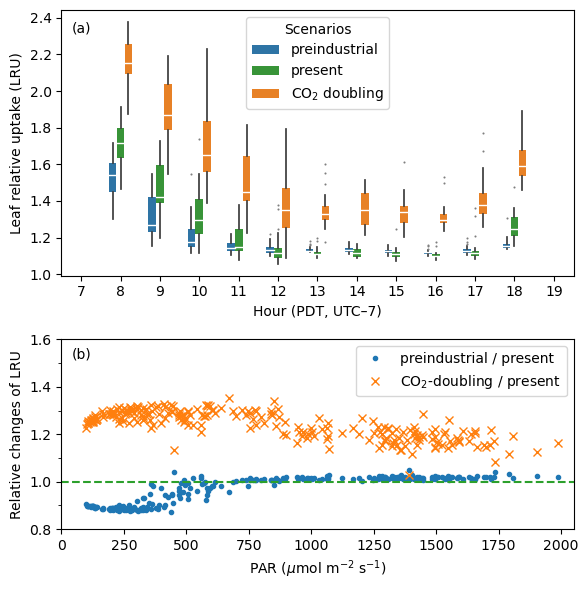

In [53]:
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[7, 5])  # grid spec of figure 9
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
# top panel
boxprops = {"linestyle": "None", "linewidth": 0.0}
medianprops = {"linestyle": "-", "color": "w"}
whiskerprops = {"linewidth": 1.25}
flierprops = {"marker": "o", "markerfacecolor": "tab:gray", "markeredgecolor": "none"}
sns.boxplot(
    ax=ax1,
    x="hour",
    y="value",
    data=df_lru_co2_realigned,
    hue="Scenarios",
    width=0.6,
    fliersize=1.5,
    saturation=0.8,
    hue_order=["preindustrial", "present", "CO$_2$ doubling"],
    palette={
        "preindustrial": "tab:blue",
        "present": "tab:green",
        "CO$_2$ doubling": "tab:orange",
    },
    linewidth=1,
    showcaps=False,
    boxprops=boxprops,
    medianprops=medianprops,
    whiskerprops=whiskerprops,
    flierprops=flierprops,
)
# edit whisker color
for j, artist in enumerate(ax1.artists):
    c = artist.get_facecolor()
    for k in range(j * 4, j * 4 + 2):
        whisker = ax1.lines[k]
        whisker.set_color(c)
        whisker.set_mfc(c)
        whisker.set_mec(c)

for leg_line in ax1.get_legend().legendHandles:
    leg_line.set_linewidth(0.0)

ax1.set_ylabel("Leaf relative uptake (LRU)")
ax1.set_xlabel("Hour (PDT, UTC–7)")
ax1.text(0.04, 0.93, "(a)", va="center", ha="center", transform=ax1.transAxes)

# bottom panel
ax2.plot(
    df_lru_co2["ppfd"],
    df_lru_co2["lru_preind"] / df_lru_co2["lru_fitted"],
    ".",
    c="tab:blue",
    label="preindustrial / present",
)
ax2.plot(
    df_lru_co2["ppfd"],
    df_lru_co2["lru_dblco2"] / df_lru_co2["lru_fitted"],
    "x",
    c="tab:orange",
    label="CO$_2$-doubling / present",
)
ax2.axhline(y=1, linestyle="dashed", color="tab:green")
ax2.set_ylim((0.8, 1.6))
ax2.set_xlim((0, 2050))
ax2.yaxis.set_minor_locator(MultipleLocator(0.1))
ax2.set_ylabel("Relative changes of LRU")
ax2.set_xlabel("PAR ($\mu$mol m$^{-2}$ s$^{-1}$)")

ax2.legend(ncol=1, loc="best")
ax2.text(0.04, 0.92, "(b)", va="center", ha="center", transform=ax2.transAxes)
fig.tight_layout()
fig.savefig(f"{dirs.plots}/marsh-lru-scenarios.pdf")

del fig, gs, ax1, ax2

### Figure 8: A schematic diagram of LRU profile in a canopy

In [54]:
# condition: mid-morning & mid-afternoon on a hot summer day in a forest canopy
test_canopy = {
    "h": 15,  # canopy height = 15 m
    "lai_density": 0.4,  # total LAI = 6 m^2 m^-2; LAI density = 0.4 m^2 m^-3
    "kappa": 0.4,
    # extinction coefficient at intermediate solar zenith angles
    # after accounting for the diffuse radiation
    "ppfd_top": 1200.0,  # PAR at canopy top = 1200 mumol m^-2 s^-1
    "T_dew": 18.0,  # assume uniform h2o profile with dew temp 18 C
}
h_canopy = np.linspace(0.0, test_canopy["h"], 151)
ppfd_canopy = test_canopy["ppfd_top"] * np.exp(
    -test_canopy["kappa"] * (test_canopy["h"] - h_canopy) * test_canopy["lai_density"]
)
co2_canopy_avg = 400.0
f_temp_morning = interpolate.interp1d(
    [0, 2, 5, 10, 15], [19, 22, 23, 23.5, 24], kind="cubic"
)
T_morning_canopy = f_temp_morning(h_canopy)
f_temp_afternoon = interpolate.interp1d(
    [0, 2, 5, 10, 15], [23, 27.5, 29.5, 30, 32], kind="cubic"
)
T_afternoon_canopy = f_temp_afternoon(h_canopy)
rh_morning_canopy = (
    p_sat_h2o(test_canopy["T_dew"]) / p_sat_h2o(T_morning_canopy) * 100.0
)
rh_afternoon_canopy = (
    p_sat_h2o(test_canopy["T_dew"]) / p_sat_h2o(T_afternoon_canopy) * 100.0
)
lru_params = coupled_params_fitted.copy()
lru_morning_canopy = rel_uptake_coupled(
    *lru_params, ppfd_canopy, rh_morning_canopy * 0.01, co2_canopy_avg
)
lru_afternoon_canopy = rel_uptake_coupled(
    *lru_params, ppfd_canopy, rh_afternoon_canopy * 0.01, co2_canopy_avg
)

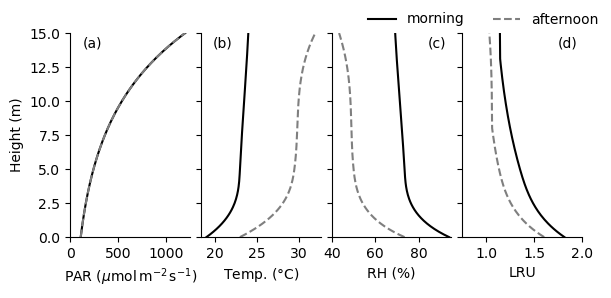

In [55]:
fig, ax = plt.subplots(1, 4, sharey=True, figsize=(6, 3))
# assume the same PAR profile for morning and afternoon cases
ax[0].plot(ppfd_canopy, h_canopy, c="k")
ax[0].plot(ppfd_canopy, h_canopy, "--", c=plt.cm.tab20(14))
ax[1].plot(T_morning_canopy, h_canopy, c="k")
ax[1].plot(T_afternoon_canopy, h_canopy, "--", c=plt.cm.tab20(14))
ax[2].plot(rh_morning_canopy, h_canopy, c="k")
ax[2].plot(rh_afternoon_canopy, h_canopy, "--", c=plt.cm.tab20(14))
ax[3].plot(lru_morning_canopy, h_canopy, c="k", label="morning")
ax[3].plot(lru_afternoon_canopy, h_canopy, "--", c=plt.cm.tab20(14), label="afternoon")

sns.despine(fig=fig)
ax[0].set_ylabel("Height (m)")
ax[0].set_xlabel("PAR ($\\mu$mol$\\,$m$^{-2}\\,$s$^{-1}$)")
ax[1].set_xlabel("Temp. ($\\degree$C)")
ax[2].set_xlabel("RH (%)")
ax[3].set_xlabel("LRU")
ax[0].set_ylim((0, 15))
ax[0].xaxis.set_major_locator(MultipleLocator(500))
ax[0].set_xlim((0, 1250))
ax[1].xaxis.set_major_locator(MultipleLocator(5))
ax[2].set_xlim((40, 95))
ax[2].xaxis.set_major_locator(MultipleLocator(20))
ax[3].set_xlim((0.75, 2))
ax[3].xaxis.set_major_locator(MultipleLocator(0.5))
for i in range(4):
    ax[i].text(
        0.1 + (i > 1) * 0.7,
        0.93,
        "(%s)" % chr(i + 97),
        transform=ax[i].transAxes,
        fontsize=10,
    )

fig.legend(handles=ax[3].lines, ncol=2, fontsize=10, loc="upper right", frameon=False)
fig.tight_layout(rect=[0.0, 0.0, 1.0, 0.95], w_pad=0.15)
fig.savefig(f"{dirs.plots}/lru-profile-schematic.pdf")

## Calculate the Ball–Berry slope and the daytime-mean internal conductance to COS

Internal conductance to COS.

In [56]:
df_ch["g_is"] = 1.0 / (
    df_ch["cos_can"] / (-df_ch["fcos_lc"])
    - lru_eqn.RATIO_GS_H2O_COS / (df_ch["g_sw"] * 1e-3)
)
df_ch.loc[
    (df_ch["daytime_indicator"] == 0) | (df_ch["fcos_lc"] > 0.0),
    "g_is",
] = np.nan
# filter g_is estimates
_q1, _q3 = np.nanquantile(df_ch["g_is"].values, [0.25, 0.75])
_inlier_lower = 2.5 * _q1 - 1.5 * _q3
_inlier_upper = 2.5 * _q3 - 1.5 * _q1
df_ch.loc[(df_ch["g_is"] < _inlier_lower) | (df_ch["g_is"] > _inlier_upper)] = np.nan

In [57]:
g_is_finite = df_ch.loc[np.isfinite(df_ch["g_is"]), "g_is"].values
g_is_mean = np.nanmean(g_is_finite)
g_is_sd = np.nanstd(g_is_finite, ddof=1)
g_is_sem = stats.sem(g_is_finite)
g_is_median = np.nanmedian(g_is_finite)

print("g_i,S summary:")
print("* mean: %.4f" % g_is_mean)
print("* std. dev.: %.4f" % g_is_sd)
print("* std. err. mean: %.4f" % g_is_sem)
print("* median: %.4f" % g_is_median)

g_i,S summary:
* mean: 0.0247
* std. dev.: 0.0170
* std. err. mean: 0.0011
* median: 0.0219


Ball–Berry slope parameter.

In [58]:
# calculate leaf surface RH
df_ch["rh_leaf"] = df_ch["h2o_can"].values * p_atm * 1e-3 / p_sat_h2o(df_ch["T_leaf"])
df_ch.loc[df_ch["rh_leaf"] > 1.0, "rh_leaf"] = 1.0  # cap RH at 100%

# calculate the Ball–Berry factor
df_ch["bb_fac"] = -df_ch["fco2_lc"] * df_ch["rh_leaf"] / df_ch["co2_can"]

Fit a robust linear model:

$$g_\mathrm{s,W}\sim\dfrac{A_\mathrm{C}\cdot h_\mathrm{s}}{\chi_\mathrm{s,C}}$$

In [59]:
idx = (
    (df_ch["daytime_indicator"] == 1)
    & (df_ch["bb_fac"] > 0.0)
    & np.isfinite(df_ch["g_sw"])
    & (df_ch["fh2o_lc"] > 0.2)
)
x1 = df_ch.loc[idx, "bb_fac"] * 1e3
y = df_ch.loc[idx, "g_sw"]
X = sm.add_constant(x1)
model = sm.RLM(y, X)
res = model.fit()
res.summary()
rsquared = stats.pearsonr(y.values, res.predict())[0] ** 2

### Figure S2: Histogram of estimates of the internal conductance to COS

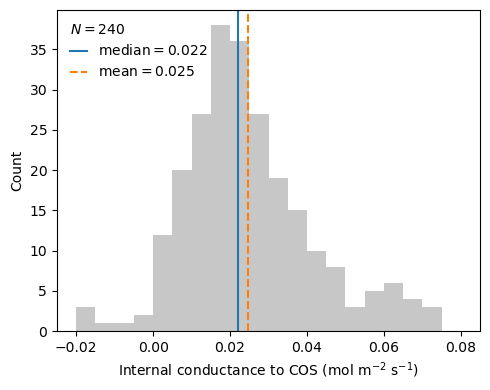

In [60]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(g_is_finite, bins=np.arange(-0.02, 0.085, 0.005), color=plt.cm.tab20(15))
ax.axvline(
    g_is_median, color="tab:blue", label="$\mathsf{median} = %.3f$" % g_is_median
)
ax.axvline(
    g_is_mean,
    color="tab:orange",
    linestyle="dashed",
    label="$\mathsf{mean} = %.3f$" % g_is_mean,
)
ax.set_xlabel("Internal conductance to COS (mol m$^{-2}$ s$^{-1}$)")
ax.set_ylabel("Count")
lg = ax.legend(
    title="$N = %i$" % len(g_is_finite),
    loc="upper left",
    handlelength=1.25,
    frameon=False,
)
lg._legend_box.align = "left"

fig.tight_layout()
fig.savefig(f"{dirs.plots}/marsh-internal-conductance.pdf")
del fig, ax, lg